# Ramdom forest

A random forest is an ensemble machine learning technique. A random forest contains many decision trees that all work together to classify new points. When a random forest is asked to classify a new point, the random forest gives that point to each of the decision trees. Each of those trees reports their classification and the random forest returns the most popular classification. It’s like every tree gets a vote, and the most popular classification wins.Some of the trees in the random forest may be overfit, but by making the prediction based on a large number of trees, overfitting will have less of an impact.

## Bootstrapping

Right now, our algorithm for creating a decision tree is deterministic — given a training set, the same tree will be made every time. To make a random forest, we use a technique called bagging, which is short for bootstrap aggregating.

How it works is as follows: every time a decision tree is made, it is created using a different subset of the points in the training set. For example, if our training set had 1000 rows in it, we could make a decision tree by picking 100 of those rows at random to build the tree. This way, every tree is different, but all trees will still be created from a portion of the training data.

In bootstrapping, we’re doing this process with replacement. Picture putting all 100 rows in a bag and reaching in and grabbing one row at random. After writing down what row we picked, we put that row back in our bag. This means that when we’re picking our 100 random rows, we could pick the same row more than once. In fact, it’s very unlikely, but all 100 randomly picked rows could all be the same row! Because we’re picking these rows with replacement, there’s no need to shrink our bagged training set from 1000 rows to 100. We can pick 1000 rows at random, and because we can get the same row more than once, we’ll still end up with a unique data set.

We’ve loaded a dataset about cars here. An important field within the dataset is the safety rating denoted by safety that can be “low”, “med”, or “high.” We’re going to implement bootstrapping and estimate the average safety rating across the different bootstrapped samples.

Distribution of safety ratings in 1728 of data:
safety
low     0.333333
med     0.333333
high    0.333333
Name: proportion, dtype: float64
Distribution of safety ratings in bootstrapped sample data:
safety
low     0.344329
high    0.333333
med     0.322338
Name: proportion, dtype: float64


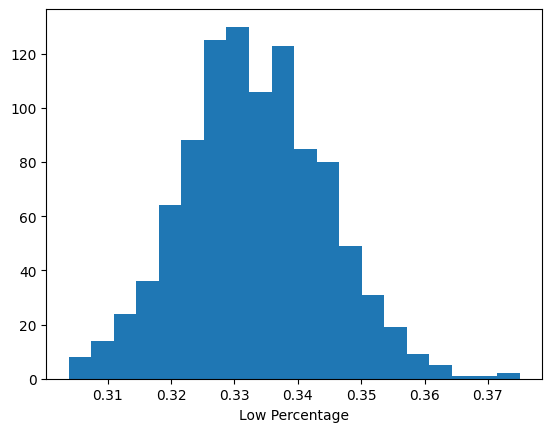

Average low percentage: 0.3332
95% Confidence Interval for low percengage: (0.3119,0.3553)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])

# Below line is transforming the 'accep' columns into a boolean series 
# where True means the car is acceptable
# and False means it is not acceptable
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable

# convert categorical variables into dummy variables (numerical ones)
# select all rows (:) and the first 6 columns of the dataframe df
# Drp the first dummy variable to avoid multicolinearity
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)
# Get number of rows. Shape returns a tuple representing database dimensions
nrows = df.shape[0]

## 1. Print number of rows and distribution of safety ratings 
print(f'Distribution of safety ratings in {nrows} of data:')
print(df.safety.value_counts(normalize=True))

## 2. Create bootstrapped sample
# Create a sample the same size as the real dataset
boot_sample = df.sample(nrows, replace=True)
print(f'Distribution of safety ratings in bootstrapped sample data:')
print(boot_sample.safety.value_counts(normalize=True))

## 3a. Create 1000 bootstrapped samples
low_perc = []
for i in range(1000):
    boot_sample = df.sample(nrows, replace=True)
    low_perc.append(boot_sample.safety.value_counts(normalize=True)['low'])

## 3b. Plot a histogram of the low percentage values
mean_lp = np.mean(low_perc) 
plt.hist(low_perc, bins=20);
plt.xlabel('Low Percentage')
plt.show()

## 4. What are the 2.5 and 97.5 percentiles?
mean_lp = np.mean(low_perc)
print(f'Average low percentage: {np.mean(low_perc).round(4)}')

low_perc.sort()
print(f'95% Confidence Interval for low percengage: ({low_perc[25].round(4)},{low_perc[975].round(4)})')

## Bagging

Random forests create different trees using a process known as bagging, which is short for bootstrapped aggregating. As we already covered bootstrapping, the process starts with creating a single decision tree on a bootstrapped sample of data points in the training set. Then after many trees have been made, the results are “aggregated” together. In the case of a classification task, often the aggregation is taking the majority vote of the individual classifiers. For regression tasks, often the aggregation is the average of the individual regressors.

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)

#original decision tree trained on full training set
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(x_train, y_train)
print(f'Accuracy score of DT on test set (trained using full set): {dt.score(x_test, y_test).round(4)}')

#2. New decision tree trained on bootstrapped sample
dt2 = DecisionTreeClassifier(max_depth=5)
#ids are the indices of the bootstrapped sample
ids = x_train.sample(x_train.shape[0], replace=True, random_state=0).index
dt2.fit(x_train.loc[ids], y_train[ids])#max_depth=50,criterion='gini')
print(f'Accuracy score of DT on test set (trained using bootstrapped sample): {dt2.score(x_test, y_test).round(4)}')

## 3. Bootstapping ten samples and aggregating the results:
preds = []
random_state = 0
for i in range(10):
    ids = x_train.sample(x_train.shape[0], replace=True, random_state=random_state+i).index
    dt2.fit(x_train.loc[ids], y_train[ids])
    preds.append(dt2.predict(x_test))   
ba_pred = np.array(preds).mean(0)

# 4. Calculate accuracy of the bagged sample
ba_accuracy = accuracy_score(ba_pred>=0.5, y_test)
print(f'Accuracy score of aggregated 10 bootstrapped samples:{ba_accuracy.round(4)}')


Accuracy score of DT on test set (trained using full set): 0.8588
Accuracy score of DT on test set (trained using bootstrapped sample): 0.8912
Accuracy score of aggregated 10 bootstrapped samples:0.9097


## Random feature selection

In addition to using bootstrapped samples of our dataset, we can continue to add variety to the ways our trees are created by randomly selecting the features that are used.

Recall that for our car data set, the original features were the following:

- The price of the car which can be “vhigh”, “high”, “med”, or “low”.
- The cost of maintaining the car which can be “vhigh”, “high”, “med”, or “low”.
- The number of doors which can be “2”, “3”, “4”, “5more”.
- The number of people the car can hold which can be “2”, “4”, or “more”.
- The size of the trunk which can be “small”, “med”, or “big”.
- The safety rating of the car which can be “low”, “med”, or “high”
- Our target variable for prediction is an acceptability rating, accep, that’s either True or False. For our final features sets, x_train and x_test, the categorical features have been dummy encoded, giving us 15 features in total.

When we use a decision tree, all the features are used and the split is chosen as the one that increases the information gain the most. While it may seem counter-intuitive, selecting a random subset of features can help in the performance of an ensemble model. In the following example, we will use a random selection of features prior to model building to add additional variance to the individual trees. While an individual tree may perform worse, sometimes the increases in variance can help model performance of the ensemble model as a whole.

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
print("Accuracy score of DT on test set (trained using full feature set):")
accuracy_dt = dt.score(x_test, y_test)
print(accuracy_dt)

# 1. Create rand_features, random samples from the set of features
rand_features = np.random.choice(x_train.columns,10)

# Make new decision tree trained on random sample of 10 features and calculate the new accuracy score
dt2 = DecisionTreeClassifier()

dt2.fit(x_train[rand_features], y_train)
print("Accuracy score of DT on test set (trained using random feature sample):")
accuracy_dt2 = dt2.score(x_test[rand_features], y_test)
print(accuracy_dt2)

# 2. Build decision trees on 10 different random samples 
predictions = []
for i in range(10):
    rand_features = np.random.choice(x_train.columns,10)
    dt2.fit(x_train[rand_features], y_train)
    predictions.append(dt2.predict(x_test[rand_features]))

## 3. Get aggregate predictions and accuracy score
prob_predictions = np.array(predictions).mean(0)
agg_predictions = (prob_predictions>0.5)
agg_accuracy = accuracy_score(agg_predictions, y_test)
print('Accuracy score of aggregated 10 samples:')
print(agg_accuracy)

Accuracy score of DT on test set (trained using full feature set):
0.9444444444444444
Accuracy score of DT on test set (trained using random feature sample):
0.7986111111111112
Accuracy score of aggregated 10 samples:
0.7638888888888888


## Scikit implementation

Much like other models we have used in scikit-learn, we instantiate a instance of BaggingClassifier() and specify the parameters. The first parameter, base_estimator refers to the machine learning model that is being bagged. In the case of random forests, the base estimator would be a decision tree. We are going to use a decision tree classifier WITH a max_depth of 5, this will be instantiated with BaggingClassifier(DecisionTreeClassifier(max_depth=5)).

After the model has been defined, methods .fit(), .predict(), .score() can be used as expected. Additional hyperparameters specific to bagging include the number of estimators (n_estimators) we want to use and the maximum number of features we’d like to keep (max_features).

Note: While we have focused on decision tress classifiers (as this is the base learner for a random forest classifier), this procedure of bagging is not specific to decision trees, and in fact can be used for any base classifier or regression model. The scikit-learn implementation is generalizable and can be used for other base models!

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)

# 1. Bagging classifier with 10 Decision Tree base estimators
bag_dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10)
bag_dt.fit(x_train, y_train)

print('Accuracy score of Bagged Classifier, 10 estimators:')
bag_accuracy = bag_dt.score(x_test, y_test)
print(bag_accuracy)

# 2.Set `max_features` to 10.
bag_dt_10 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10, max_features=10)
bag_dt_10.fit(x_train, y_train)

print('Accuracy score of Bagged Classifier, 10 estimators, 10 max features:')
bag_accuracy_10 = bag_dt_10.score(x_test, y_test)
print(bag_accuracy_10)


# 3. Change base estimator to Logistic Regression
from sklearn.linear_model import LogisticRegression
bag_lr = BaggingClassifier(base_estimator=LogisticRegression(),
                         n_estimators=10, max_features=10)
bag_lr.fit(x_train, y_train)

print('Accuracy score of Logistic Regression, 10 estimators:')
bag_accuracy_lr = bag_lr.score(x_test, y_test)
print(bag_accuracy_lr)


Accuracy score of Bagged Classifier, 10 estimators:
0.9212962962962963
Accuracy score of Bagged Classifier, 10 estimators, 10 max features:
0.8726851851851852
Accuracy score of Logistic Regression, 10 estimators:
0.9143518518518519


c:\Users\alan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\alan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\alan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)

# 1. Create a Random Forest Classifier and print its parameters

rf = RandomForestClassifier()
print('Random Forest parameters:')
rf_params = rf.get_params()
print(rf_params)

# 2. Fit the Random Forest Classifier to training data and calculate accuracy score on the test data
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
rf_accuracy = rf.score(x_test, y_test)

print('Test set accuracy:', rf_accuracy)

# 3. Calculate Precision and Recall scores and the Confusion Matrix

rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_confusion_matrix = confusion_matrix(y_test, y_pred)

print(f'Test set precision: {rf_precision}')
print(f'Test set recall: {rf_recall}')
print(f'Test set confusion matrix:\n{rf_confusion_matrix}')


Random Forest parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Test set accuracy: 0.9490740740740741
Test set precision: 0.9523809523809523
Test set recall: 0.8823529411764706
Test set confusion matrix:
[[290   6]
 [ 16 120]]


## Random Forest Regressor

Just like in decision trees, we can use random forests for regression as well! It is important to know when to use regression or classification — this usually comes down to what type of variable your target is. Previously, we were using a binary categorical variable (acceptable versus not), so a classification model was used.

We will now consider a hypothetical new target variable, price, for this data set, which is a continuous variable. We’ve generated some fake prices in the dataset so that we have numerical values instead of the previous categorical variables. (Please note that these are not reflective of the previous categories of high and low prices - we just wanted some numeric values so we can perform regression! :) )

Now, instead of a classification task, we will use scikit-learn‘s RandomForestRegressor() to carry out a regression task.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)

## Generating some fake prices for regression! :) 
fake_prices = (15000 + 25*df.index.values)+np.random.normal(size=df.shape[0])*5000
df['price'] = fake_prices
print(df.price.describe())
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)

# 1. Create a Random Regressor and print `R^2` scores on training and test data
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)

r_squared_train = rfr.score(x_train, y_train)
print(f'Train set R^2: {r_squared_train}')

r_squared_test = rfr.score(x_test, y_test)
print(f'Test set R^2: {r_squared_test}')

# 2. Print Mean Absolute Error on training and test data

avg_price = y.mean()
print(f'Avg Price Train/Test: {avg_price}')

y_pred_train =rfr.predict(x_train)
y_pred_test =rfr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train set MAE: {mae_train}')

mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test set MAE: {mae_test}')